In [196]:
import matplotlib.pyplot as plt
import numpy as np
import sys;
sys.path.append("c:/dev/pycode/")
import common.power_law_analysis as pl
import glob
import pandas as pd
import common.power_spectrum as pow_spec
import scipy.interpolate as interpolate

ptomm = 216/1920 # px to mm factor for Samsung T580

def load_trace(filename):
    d = pd.read_csv(filename, sep=" ", names = ["t", "x", "y"])
    d.t = d.t/1000.0  # convert ms to seconds
    d.y = 1200.0 - d.y  # invert y axis, tablet's (0,0) is in upper left corner 
    d['xmm'] = d.x * ptomm
    d['ymm'] = d.y * ptomm
    d['filename'] = filename
    return d


def load_path(fname):
    d = pd.read_csv(fname, sep=" ", names = ["x", "y"])
    d.y = 1200.0 - d.y  # invert y axis, tablet's (0,0) is in upper left corner 
    d['xmm'] = d.x * ptomm
    d['ymm'] = d.y * ptomm
    return d
    

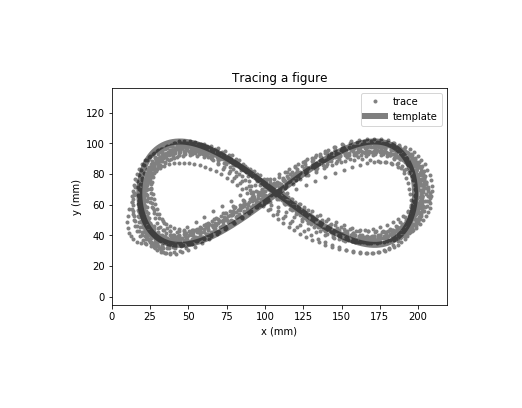

In [113]:
fdraw = glob.glob("c:/dev/baw/data-new/*tracing lemniscate*")[0]
d = load_trace(fdraw)
ftemp = glob.glob("c:/dev/baw/data-new/*LemniscatePath*")[0]
tt = load_path(ftemp)
c = 200
ptom = 216/1920
plt.plot(d.xmm[c:-c], d.ymm[c:-c], '.', color="gray", label="trace")
plt.plot(tt.xmm, tt.ymm, color="black", lw=6, alpha = 0.5, label="template")

plt.legend()
plt.title("Tracing a figure")
plt.axis("equal")

plt.xlim([0, 1920*ptom]); plt.ylim([0, 1200*ptom])
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.savefig("c:/dev/baw/plots/trace lemniscate.svg", format="svg")
plt.show()


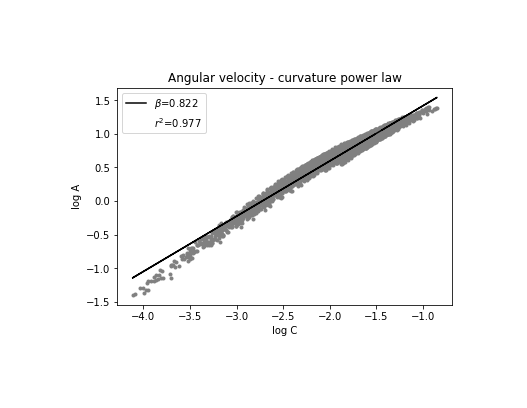

In [105]:
# analyze lemniscate trace
d.r = pl.analyze([d.xmm, d.ymm, d.t], butter=8, cut=1)
N = len(d.r["logC"])
filt = [i for i in range(N) if d.r["RC"][i] < 1500*10]
logC= d.r["logC"][filt]
logA = d.r["logA"][filt]

plt.title("Angular velocity - curvature power law")
plt.plot(logC, logA, '.', color="gray")
reg_line1 = [d.r['beta'] * i + d.r['offset'] for i in logC]
plt.plot(logC, reg_line1, color="black", label=r"$\beta$={:.3f}".format(d.r["beta"]))
plt.plot([],[], color="white", label="$r^2$={:.3f}".format(d.r["r2"]))
plt.legend()
plt.xlabel("log C")
plt.ylabel("log A")
plt.savefig("c:/dev/baw/plots/power law.svg", format="svg")
plt.show()

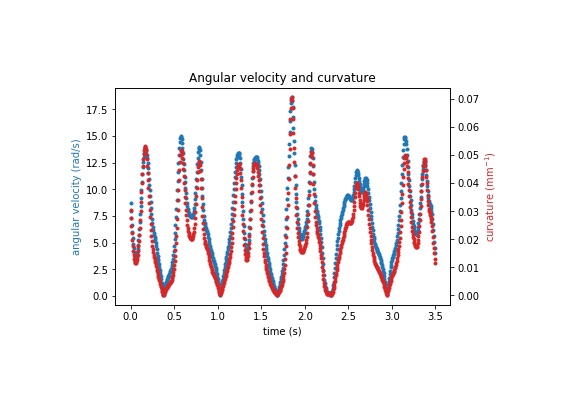

In [106]:
take = 700
c1 = "tab:blue"
c2 = "tab:red"
fig, ax1 = plt.subplots()
ax1.set_xlabel("time (s)")
ax1.set_ylabel("angular velocity (rad/s)", color=c1)
ax1.plot(d.r["t"][:take], d.r["Avel"][:take], ".", color=c1)
ax2 = ax1.twinx()
ax2.plot(d.r["t"][:take], d.r["C"][:take], ".", color= c2)
ax2.set_ylabel(r"curvature (mm$^{-1}$)", color=c2)
plt.title("Angular velocity and curvature")
plt.savefig("c:/dev/baw/plots/velcurvtime.svg", format="svg")

In [194]:
def resample(ts_raw, xs, dt, start=0, end=25):
    xc = np.copy(xs)
    x_spline = interpolate.UnivariateSpline(ts_raw, xc, k=3, s=0)
    new_ts = np.arange(start, end, dt)
    new_xs = x_spline(new_ts)
    return new_ts, new_xs

def ellipse_lead_follow(user_file, target_file, dt = 0.020, start = 2, end = 25):
    ud = load_trace(user_file) 
    td = load_trace(target_file) 
    cx = (0.5 * (np.min(td.x) + np.max(td.x)))
    cy = (0.5 * (np.min(td.y) + np.max(td.y)))
    N = len(ud.x)
    
    ut = np.arange(start, end, dt)
    ux = interpolate.UnivariateSpline(ud.t, ud.x, k=3, s=0)(ut)
    uy = interpolate.UnivariateSpline(ud.t, ud.y, k=3, s=0)(ut)
    
    tt = ut
    tx = interpolate.UnivariateSpline(td.t, td.x, k=3, s=0)(tt)
    ty = interpolate.UnivariateSpline(td.t, td.y, k=3, s=0)(tt)

    pht = np.unwrap(np.arctan2(ty - cy, tx - cx))
    phu = np.unwrap(np.arctan2(uy - cy, ux - cx))
    dph = pht - phu
    
    return pd.DataFrame ({"ut": ut, "ux": ux, "uy":uy,
                          "tt": tt, "tx": tx, "ty": ty,
                          "pht":pht, "phu": phu, "dph": dph}) 

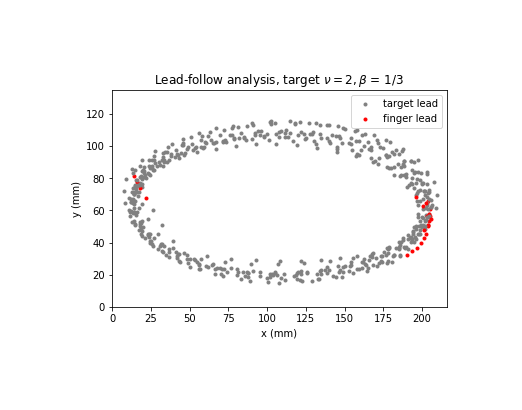

In [201]:
fs = glob.glob("c:/dev/baw/data-new/*track*10.4.2019*.txt");fs
r = ellipse_lead_follow(fs[2], fs[0], 0.04, 4.1, 28) ## hiponatural
colors = lambda x: (["gray","black", "red"])[int(x)]
for i in range(len(r.ux)):
    plt.scatter(r.ux[i]*ptomm, r.uy[i]*ptomm, c= colors(np.sign(r.dph[i])+1)  , marker='.')

plt.title(r"Lead-follow analysis, target $\nu = 2, \beta$ = 1/3")    
plt.xlim([0, 1920*ptom]); plt.ylim([0, 1200*ptom])
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.scatter([],[],color="gray", marker=".", label="target lead")
plt.scatter([],[],color="red", marker=".", label="finger lead")
plt.legend()
plt.savefig("c:/dev/baw/plots/lead-follow1.svg", format="svg")

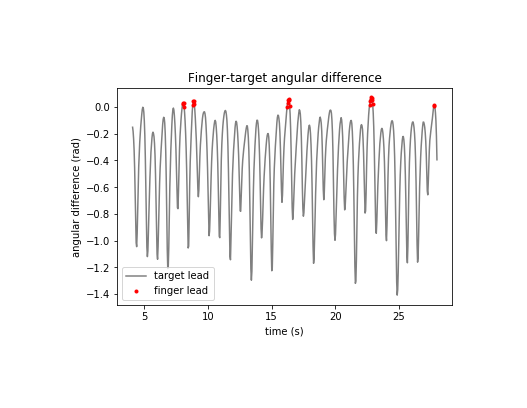

In [203]:
lims = [i for i in range(len(r.dph)) if  r.dph[i] > 0]
plt.plot(r.tt, r.dph,  color = "gray", label="target lead")
plt.plot(r.tt[lims], r.dph[lims], ".", color="red", label="finger lead")
plt.title("Finger-target angular difference")
plt.xlabel("time (s)")
plt.ylabel("angular difference (rad)")
plt.legend()

plt.savefig("c:/dev/baw/plots/lead-follow2.svg", format="svg")

In [186]:
def load_get_PS(f):
    d = load_path(f)
    d.t = np.arange(len(d.x)) * 0.001
    d.F, d.Y = pow_spec.get_power_spectrum_c(d.x, d.y, d.t)
    return d


In [187]:
fs = glob.glob("c:/dev/baw/data-new/*tracing flower4*.txt")[:1] +  \
     glob.glob("c:/dev/baw/data-new/*scribble*.txt")[:-1] + \
     glob.glob("c:/dev/baw/data-new/*tracing flower3*.txt")[:1] +  \
     glob.glob("c:/dev/baw/data-new/*tracing ellipse*.txt")[:1] 

In [188]:
ds = {}
ds["flower4_user"] = load_get_PS(fs[0])
ds["scribble"] = load_get_PS(fs[1])
ds["flower3_user"] = load_get_PS(fs[2])
ds["ellipse_user"] = load_get_PS(fs[3])


C:\Dev\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Dev\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


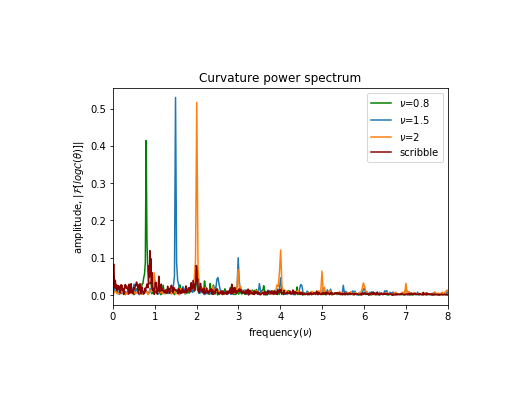

In [181]:
plt.plot(ds["flower4_user"].F, ds["flower4_user"].Y, label=r"$\nu$=0.8", color="green")    
plt.plot(ds["flower3_user"].F, ds["flower3_user"].Y, label=r"$\nu$=1.5", color="tab:blue")    
plt.plot(ds["ellipse_user"].F, ds["ellipse_user"].Y, label=r"$\nu$=2", color="tab:orange")    
plt.plot(ds["scribble"].F, ds["scribble"].Y, label="scribble", color = "darkred")  
  
plt.xlim([0, 8])
plt.xlabel(r"frequency($\nu$)")
plt.ylabel(r"amplitude, |$ \mathcal{F}[log \mathcal{C}(\theta) ] $| ")
plt.title("Curvature power spectrum")
plt.legend()
plt.savefig("c:/dev/baw/plots/pure_freq2.svg", format="svg")

plt.show()


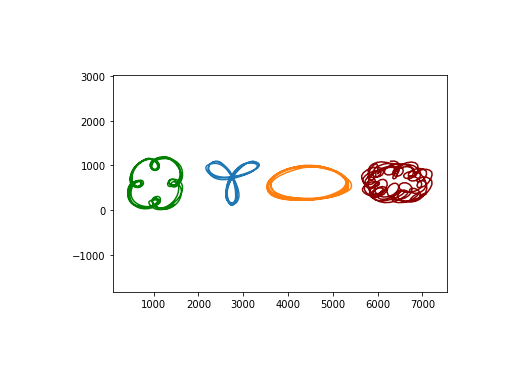

In [189]:
take = -1500
step = 2
plt.plot(ds["flower4_user"].x[:take:step], ds["flower4_user"].y[:take:step], color="green")

take = -2000
step = 2
plt.plot(ds["flower3_user"].x[:take:step] + 1800, ds["flower3_user"].y[:take:step], color="tab:blue")

take = -2000
step = 2
plt.plot(ds["ellipse_user"].x[:take:step] + 3500, ds["ellipse_user"].y[:take:step], color="tab:orange")

take = -1500
step = 2
plt.plot(ds["scribble"].x[:take:step] + 5500, ds["scribble"].y[:take:step], color="darkred")


plt.axis("equal")

plt.savefig("c:/dev/baw/plots/spectrum_traces.svg", format="svg")

In [92]:
### segmentation

cx = 963.0
cy = 466.0
r = 1500.0   # area triangle size

angles = np.arange(0.5, 7.5, 1.0) *  (np.pi*2.0) /6.0
x_points =  [cx + r*np.cos(a) for a in angles] 
y_points =  [cy + r*np.sin(a) for a in angles] 

rm = 250 # center radius size for exclusion

distance = lambda x1, y1, x2, y2: np.sqrt((x2-x1)**2 + (y2-y1)**2)

triangles = [ [(cx, cy), (x_points[i], y_points[i]), (x_points[i+1], y_points[i+1])] for i in range(6)]

def subtract(A,B):
    return (A[0] - B[0], A[1] - B[1])

def SameSide(p1, p2, a, b):
    cp1 = np.cross(subtract(b, a), subtract(p1, a))
    cp2 = np.cross(subtract(b, a), subtract(p2, a))
    return (np.dot(cp1, cp2) >= 0)

def PointInTriangle(p, a, b, c):
    return (SameSide(p, a, b,c) and SameSide(p, b, a, c) and SameSide(p, c, a, b))

def whichTriangle(p):
    if distance (cx, cy, p[0], p[1]) < rm:
        return 6
    for i in range(6):
        if (PointInTriangle(p, *(triangles[i]))):
            return i
    return 6

colors = ["red", "green", "blue", "cyan", "yellow", "brown", "black"]

def get_segments(t):
    return np.asarray([whichTriangle((a, b)) for a, b in zip(t.x, t.y)])    

def get_sequence_no_center(t):
    segment0 = get_segments(t)
    index = np.argwhere(segment0==6) # 6 is center
    no_center = np.delete(segment0, index)
    repeats = np.diff(no_center)
    final = no_center[:-1][repeats != 0]
    return final

def get_sequence(t):
    segment0 = get_segments(t)
    repeats = np.diff(segment0)
    final = segment0[:-1][repeats != 0]
    return final

c:/dev/baw/data-new\February1986MasDer tracing flower3 12.4.2019. 17.52.42.txt


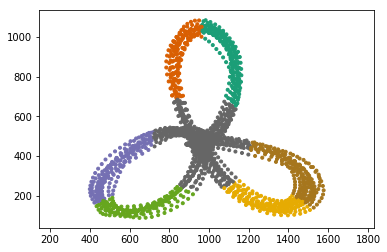

In [136]:
fs = glob.glob("c:/dev/baw/data-new/*flower3*2019*.txt")
for f in fs[1:2]:
    print(f)
    d = pd.read_csv(f, sep=" ", names = ["t", "x", "y"])
    c = get_segments(d)
    #filt = [i for i in range(len(c)) if c[i] != 6]    
    #plt.scatter(d.x[filt], d.y[filt], c=c[filt], cmap="Accent", marker='.')
    
    plt.scatter(d.x, d.y, c=c, cmap="Dark2", marker='.')
    plt.axis("equal")
    plt.savefig("c:/dev/baw/plots/Segmentation_two.svg", format="svg")
    plt.show()

In [93]:

fs = glob.glob("c:/dev/baw/data-new/*flower3*2019*.txt")
segs = [ get_sequence(pd.read_csv(f, sep=" ", names = ["t", "x", "y"])) for f in fs]
    

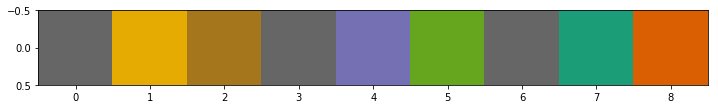

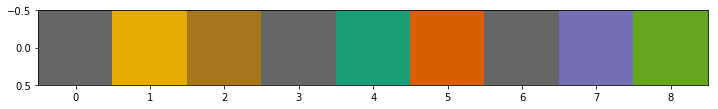

In [152]:
a = segs[2].argmax(0)
b = segs[0].argmax(0)
c = segs[1].argmax(0)

q1 = pd.DataFrame([(segs[0][b+1:b+10])[::-1]])
q2 = pd.DataFrame([segs[1][c:c+9]])

plt.figure(figsize=[12, 4])
plt.imshow(q1, cmap="Dark2")
plt.savefig("c:/dev/baw/plots/Segmentation-sequence.svg", format="svg")
plt.show()

plt.figure(figsize=[12, 4])
plt.imshow(q2, cmap="Dark2")
plt.savefig("c:/dev/baw/plots/Segmentation-sequence-two.svg", format="svg")
plt.show()

In [140]:
f = r"C:/dev/baw/data-new\February1986MasDer scribble 21.3.2019. 15.23.12.txt"
d = load_trace(f)
d.r = pl.analyze([d.xmm, d.ymm, d.t], butter=8, cut=1)
N = len(d.r["x"])
phi0 = [np.arctan2(d.r["y"][i] - d.r["y"][i-1], d.r["x"][i] - d.r["x"][i-1]) for i in range(1, N)]
phi = np.unwrap(phi0)

cc = np.sign(np.diff(phi))
colors = lambda q: ["tab:red", "black", "tab:blue"][int(q)]


C:\Dev\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


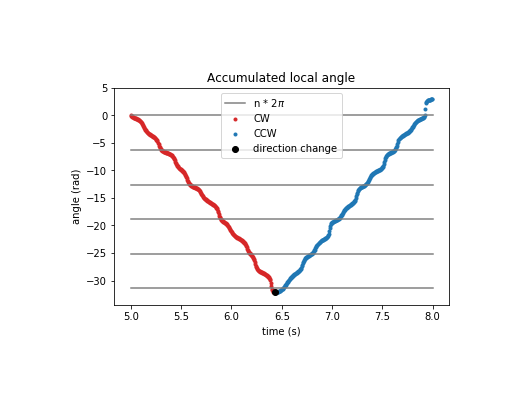

In [191]:
plt.title("Accumulated local angle")

for i in np.arange(0, -32, -2*np.pi):
    plt.plot([5, 8], [i, i], color="gray")

for i in range(1000, 1600):
    plt.scatter(d.r["t"][i], phi[i] - phi[1000], c=colors(cc[i] + 1), marker = '.')


i = 1286

plt.scatter([],[], c=colors(0), marker = '.', label="CW")
plt.scatter([],[], c=colors(2), marker = '.', label="CCW")
plt.plot([], [], c="gray", label=r"n * 2$\pi$")
plt.scatter(d.r["t"][i], phi[i] - phi[1000], color="black", marker = 'o', label="direction change")    


plt.ylabel("angle (rad)")
plt.xlabel("time (s)")
plt.legend()
plt.savefig("c:/dev/baw/plots/local_angle.svg", format="svg")
plt.show()

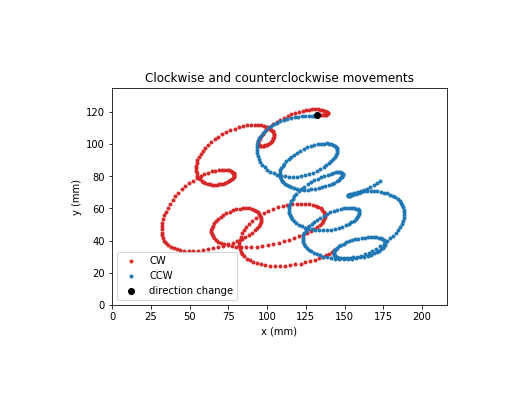

In [166]:

x = d.r["x"][1:-1]
y = d.r["y"][1:-1]

for i in range(1000, 1600):
    plt.scatter(x[i], y[i], c=colors(cc[i] + 1), marker = '.')

plt.xlim([0, 1920*ptom]); plt.ylim([0, 1200*ptom])

plt.scatter([],[], c=colors(0), marker = '.', label="CW")
plt.scatter([],[], c=colors(2), marker = '.', label="CCW")

i = 1286
plt.scatter(x[i], y[i], color="black", marker = 'o', label="direction change")    

plt.title("Clockwise and counterclockwise movements")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.legend()
plt.savefig("c:/dev/baw/plots/cwccw.svg", format="svg")

plt.show()

    

In [27]:
fs = glob.glob("C:/dev/baw/data-new/*user*tracking*"); fs[0]
duser = pd.read_csv(fs[0], sep=" ", names = ["t", "x", "y"]);

fss = glob.glob("C:/dev/baw/data-new/*target*tracking*"); fss[0]
dtarget = pd.read_csv(fss[0], sep=" ", names = ["t", "x", "y"]);

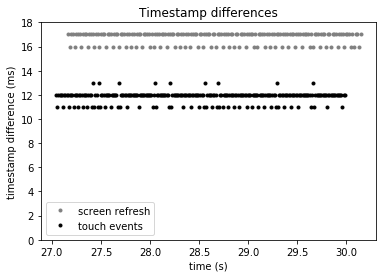

In [41]:
plt.title("Timestamp differences")
take = 180
plt.plot(dtarget.t[-take:-1] / 1000.0, np.diff(dtarget.t[-take:]), ".", label="screen refresh", color="gray")
take = 250
plt.plot(duser.t[-take:-1] / 1000.0, np.diff(duser.t[-take:]), ".", label="touch events", color="black")
plt.ylim([0, 18])
plt.ylabel("timestamp difference (ms)")
plt.xlabel("time (s)")
plt.legend()
plt.savefig("C:/dev/baw/plots/timestamps.svg", format="svg")
plt.show()